# Importing Libraries and Data

In [250]:
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sn
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import load_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from joblib import dump, load
import lightgbm as lgb

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

In [170]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [171]:
train_data[train_data.columns[1:]].values

array([['A', 'B', 'A', ..., 0.822493, 0.714843, 2213.18],
       ['A', 'B', 'A', ..., 0.6114310000000001, 0.304496, 1283.6],
       ['A', 'B', 'A', ..., 0.195709, 0.774425, 3005.09],
       ...,
       ['A', 'B', 'A', ..., 0.339244, 0.503888, 5762.64],
       ['A', 'B', 'A', ..., 0.654753, 0.721707, 1562.87],
       ['B', 'A', 'A', ..., 0.810511, 0.72146, 4751.72]], dtype=object)

# Pre-Processing data 

In [172]:
y_train=train_data['loss']

In [173]:
shift = 200


In [174]:

top_cat_feats = "cat80,cat79,cat87,cat57,cat101,cat12,cat81,cat7,cat89,cat10,cat1,cat72,cat2,cat94,cat103,cat111,cat114,cat11,cat53,cat106,cat9,cat13,cat38,cat100,cat105,cat44,cat108,cat75,cat109,cat90,cat116,cat6,cat5,cat25".split(',')


In [175]:
# (Please note that all the comments in all the functions are written by me 
# for clear understanding of the code/function)

In [176]:
#https://www.kaggle.com/modkzs/lexical-encoding-feature-comb/code
def encode(string):
    '''Using unicode encoding to encode the categorical variables , this encoding uses relative position of the 
    alphabet to encode the categorical variables'''
    r = 0
    length = len(str(string))
    for i in range(length):
        # unicode of the alphabet - unicode of first letter 
        # +1 to give maintain non zero postion
        # *26 for equating all the alphabets to a level as 26 is total number of alphabets 
        # To the power of the position of the charcode 
        r += (ord(str(string)[i]) - ord('A') + 1) * 26 ** (length - i - 1)
    return r

In [177]:

# As ref:https://www.kaggle.com/c/allstate-claims-severity/discussion/24520#140255
fair_constant = 0.7
def fair_obj(preds, dtrain):
    """As discussed in the Literature survey , XGboost doesn't directly consider MAE as metric , 
    so to overcome that issue we use fair_obj"""
    # We use a small constant of 0.7 as to make it the function continous 
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

In [178]:

def xg_eval_mae(yhat, dtrain):
    """Evaluation metric """
#     y = dtrain.get_label()
    return  mean_absolute_error(np.exp(dtrain)-shift,
                                      np.exp(yhat)-shift)

In [179]:
def mungeskewed(train, test, numeric_feats):
    '''This function checks for skewness in the categorical features and applies box-cox transformation'''
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    # Calculating the skewness on the entire data's features 
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    # seperating the features which have higher than 0.25 skewness 
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    # Transforming all the highly skewed variables with BOX-cox 
    # Data leakage is avoided by checking the skewness on train_data only and skipping the test data
    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

In [180]:
numeric_feats = [x for x in train_data.columns[1:-1] if 'cont' in x]
categorical_feats = [x for x in train_data.columns[1:-1] if 'cat' in x]
train_test, ntrain = mungeskewed(train_data, test_data, numeric_feats)

In [181]:
# taken from Vladimir's script (https://www.kaggle.com/iglovikov/allstate-claims-severity/xgb-1114)

# Checking for same data occurances in train and test data and removing the same occurances 
for column in list(train_data.select_dtypes(include=['object']).columns):
    if train_data[column].nunique() != test_data[column].nunique():
        set_train = set(train_data[column].unique())
        set_test = set(test_data[column].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train

        remove = remove_train.union(remove_test)


        def filter_cat(x):
            if x in remove:
                return np.nan
            return x


        train_test[column] = train_test[column].apply(lambda x: filter_cat(x), 1)

In [316]:
train = train_test.iloc[:ntrain, :].copy()
test = train_test.iloc[ntrain:, :].copy()

**Preprocessing of continuous variables**

In [317]:
from sklearn.preprocessing import MinMaxScaler

In [241]:
cont_vars=['cont1','cont4','cont5','cont8','cont10','cont11','cont12','cont6','cont7','cont9','cont13','cont14']

In [242]:
max_cont_vars=[]
for vars in cont_vars:
    max_cont_vars.append(train[vars].max(axis=0))

In [243]:
min_cont_vars=[]
for vars in cont_vars:
    min_cont_vars.append(train[vars].min(axis=0))

In [267]:
data = {
        'max':max_cont_vars,
       'min':min_cont_vars}

# Create DataFrame
df = pd.DataFrame(data)

In [268]:
min_max_data=df.transpose()

In [270]:
min_max_data.columns=cont_vars

In [271]:
min_max_data

,cont1,cont4,cont5,cont8,cont10,cont11,cont12,cont6,cont7,cont9,cont13,cont14
max,0.564777,0.489006,0.290097,0.346306,0.5629,0.597473,0.590910,0.506648,0.347950,0.323742,0.436256,0.844848
min,0.000016,0.150383,0.174663,0.168492,0.0000,0.034449,0.035295,0.012528,0.062292,0.000080,0.000228,0.179722


In [272]:
dump(min_max_data, open('min_max_scale.pkl', 'wb'))
scale = load(open('min_max_scale.pkl', 'rb'))

In [294]:
mimx_scale_data=scale

In [318]:
# Referenced from Ali's script (https://www.kaggle.com/aliajouz/allstate-claims-severity/singel-model-lb-1117)

train["cont1"] = np.sqrt(preprocessing.minmax_scale(train["cont1"]))

train["cont4"] = np.sqrt(preprocessing.minmax_scale(train["cont4"]))

train["cont5"] = np.sqrt(preprocessing.minmax_scale(train["cont5"]))

train["cont8"] = np.sqrt(preprocessing.minmax_scale(train["cont8"]))

train["cont10"] = np.sqrt(preprocessing.minmax_scale(train["cont10"]))

train["cont11"] = np.sqrt(preprocessing.minmax_scale(train["cont11"]))

train["cont12"] = np.sqrt(preprocessing.minmax_scale(train["cont12"]))

train["cont6"] = np.log(preprocessing.minmax_scale(train["cont6"]) + 0000.1)

train["cont7"] = np.log(preprocessing.minmax_scale(train["cont7"]) + 0000.1)

train["cont9"] = np.log(preprocessing.minmax_scale(train["cont9"]) + 0000.1)

train["cont13"] = np.log(preprocessing.minmax_scale(train["cont13"]) + 0000.1)

train["cont14"] = (np.maximum(train["cont14"] - 0.179722, 0) / 0.665122) ** 0.25

In [319]:
# Referenced from Ali's script (https://www.kaggle.com/aliajouz/allstate-claims-severity/singel-model-lb-1117)
test["cont1"] = np.sqrt(preprocessing.minmax_scale(test["cont1"]))
test["cont4"] = np.sqrt(preprocessing.minmax_scale(test["cont4"]))
test["cont5"] = np.sqrt(preprocessing.minmax_scale(test["cont5"]))
test["cont8"] = np.sqrt(preprocessing.minmax_scale(test["cont8"]))
test["cont10"] = np.sqrt(preprocessing.minmax_scale(test["cont10"]))
test["cont11"] = np.sqrt(preprocessing.minmax_scale(test["cont11"]))
test["cont12"] = np.sqrt(preprocessing.minmax_scale(test["cont12"]))

test["cont6"] = np.log(preprocessing.minmax_scale(test["cont6"]) + 0000.1)
test["cont7"] = np.log(preprocessing.minmax_scale(test["cont7"]) + 0000.1)
test["cont9"] = np.log(preprocessing.minmax_scale(test["cont9"]) + 0000.1)
test["cont13"] = np.log(preprocessing.minmax_scale(test["cont13"]) + 0000.1)
test["cont14"] = (np.maximum(test["cont14"] - 0.179722, 0) / 0.665122) ** 0.25

**Additional features by combining the some of the categorical features**

In [320]:
print('Combining Columns')

for comb in tqdm( itertools.combinations(top_cat_feats, 2)):
    feat = comb[0] + "_" + comb[1]
    train[feat] = train[comb[0]] + train[comb[1]]
    train[feat] = train[feat].apply(encode)

print('Encoding columns')
for col in tqdm(categorical_feats):
    train[col] = train[col].apply(encode)


ss = StandardScaler()
train[numeric_feats] = ss.fit_transform(train[numeric_feats].values)
dump(ss, open('tot_data_scale.pkl', 'wb'))

Combining Columns



Encoding columns


In [321]:
print('Combining Columns')

for comb in tqdm( itertools.combinations(top_cat_feats, 2)):
    feat = comb[0] + "_" + comb[1]
    test[feat] = test[comb[0]] + test[comb[1]]
    test[feat] = test[feat].apply(encode)

print('Encoding columns')
for col in tqdm(categorical_feats):
    test[col] = test[col].apply(encode)


ss = StandardScaler()
test[numeric_feats] = ss.fit_transform(test[numeric_feats].values)

Combining Columns



Encoding columns


# Obtaining Auto-Encoded features

In [130]:
train_data1=train_data.copy()
k=[]
enc_dict={}
for col in train_data1.select_dtypes(include=['object']).columns:
    enc = LabelEncoder()
    k=enc.fit_transform(train_data1[col].values)
    

In [ ]:
dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
scaler = load(open('scaler.pkl', 'rb'))

In [ ]:
X_test_scaled = scaler.transform(X_test)

In [322]:
train_data1=train_data.copy()
column_enc=[]
encoders=[]
for col in train_data1.select_dtypes(include=['object']).columns:
    enc = LabelEncoder()
    enc.fit(train_data1[col])
    train_data1[col] =enc.transform(train_data1[col])
    encoders.append(enc)
    column_enc.append(col)
#     train_data1=train_data1.drop("loss",axis=1)

In [323]:
res = {column_enc[i]: encoders[i] for i in range(len(column_enc))}
  
# Printstr(res))

In [324]:
dump(res, open('auto_scaler.pkl', 'wb'))
auto_res = load(open('auto_scaler.pkl', 'rb'))

In [20]:
encoder = load_model('encoder1.h5',compile=False)

encoder.run_eagerly = True
X_train_encode=encoder.predict(train_data1[train_data.columns[1:-1]])

train_final = np.concatenate((train.drop(['loss','id'],axis=1), X_train_encode), axis=1)

In [21]:
test_data1=test_data.copy()
for col in test_data1.select_dtypes(include=['object']).columns:
    enc = LabelEncoder()
    
    test_data1[col] = enc.fit_transform(test_data1[col])

In [22]:
X_test_encode=encoder.predict(test_data1[train_data.columns[1:-1]])

test_final = np.concatenate((test.drop(['loss','id'],axis=1), X_test_encode), axis=1)

In [23]:

print('\nMedian Loss:', train.loss.median())
print('Mean Loss:', train.loss.mean())

ids = pd.read_csv('test.csv')['id']
train_y = np.log(train['loss'] + shift)
train_x = train_final
test_x = test_final


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792


# Train-test split

In [24]:
X_train_a, X_validation_a, y_train_a, y_validation_a= train_test_split(train_x,train_y, train_size=0.7, random_state=1234)

# Model-1 Linear regression

In [340]:
from sklearn.linear_model import LinearRegression
# define the model
linear_model =LinearRegression()
# fit the model on the training set

linear_model.fit(X_train_a, y_train_a)
# make predictions on the test set
yhat = linear_model.predict(X_validation_a)
# calculate classification mae


In [341]:
tr=np.exp(y_validation_a).values-shift

In [342]:
acc = mean_absolute_error(tr,pre)
print(acc)

1290.9839887950113


# Model-2 Ridge 

In [343]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from scipy.stats import loguniform



In [344]:
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
# define search space
space = dict()
# space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
# space['fit_intercept'] = [True, False]
# space['normalize'] = [True, False]
# define search
search = RandomizedSearchCV(model, space, n_iter=3, scoring='neg_mean_absolute_error', n_jobs=-1,verbose=3, cv=cv, random_state=1)
# execute search
result = search.fit(X_train_a, y_train_a)
# summarize result
# print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 9 folds for each of 3 candidates, totalling 27 fits
Best Hyperparameters: {'alpha': 0.008301451461243866}


/Users/rupesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.03993e-16): result may not be accurate.
  overwrite_a=True).T


In [345]:
ridge_model= Ridge(alpha= 1.10222803767004)
ridge_model.fit(X_train_a, y_train_a)

Ridge(alpha=1.10222803767004)

In [346]:
pred=ridge_model.predict(X_validation_a)

In [347]:
xg_eval_mae(pred,y_validation_a)

1288.9717906134154

# Model-3 Random_forest Regressor

In [348]:
from sklearn.ensemble import RandomForestRegressor

n_list = np.array([25,50,100,125,150])




train_mae_result=[]
test_mae_result=[]

comb=[]
for n_estimators in tqdm(n_list):
    #Set the base model
    model = RandomForestRegressor(n_jobs=-1,n_estimators=n_estimators)
    
    model.fit(X_train_a, y_train_a)
    train_result=xg_eval_mae(y_train_a,(model.predict(X_train_a)))
    train_mae_result.append(train_result)
    
    val_result = xg_eval_mae(y_validation_a,(model.predict(X_validation_a)))
    test_mae_result.append(val_result)
        
    comb.append(n_estimators)

  


    

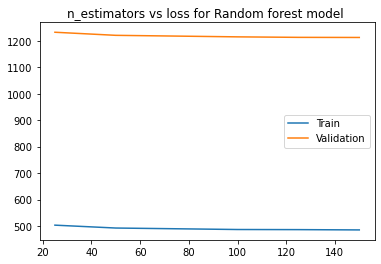

In [350]:
plt.plot(comb,train_mae_result)
plt.plot(comb,test_mae_result)
plt.title("n_estimators vs loss for Random forest model ")

plt.legend(["Train", "Validation"])

With the above plot we get to see that there is not a lot of varaiation in performance as the depths 

In [748]:
best_estimators=1100

In [749]:

best_model_rf = RandomForestRegressor(n_jobs=-1,n_estimators=best_estimators)
best_model_rf.fit(X_train_a, y_train_a)
preds=best_model_rf.predict(X_validation_a)
best_rf_score =xg_eval_mae(preds,y_validation_a)
print("The best validation score of random forest is :",best_rf_score)
    

The best validation score of random forest is : 1209.4059884125072


# Model-4 Light GBM

In [42]:
import lightgbm as lgb

In [451]:

n_list = np.array([10,15,20,25,30])


train_mae_result=[]
test_mae_result=[]

comb=[]
for depths in tqdm(n_list):
    #Set the base model
    model = lgb.LGBMRegressor(n_jobs=-1,n_estimators=1100,max_depth=depths)
    
    model.fit(X_train_a, y_train_a)
    train_result=xg_eval_mae(y_train_a,(model.predict(X_train_a)))
    train_mae_result.append(train_result)
    
    val_result = xg_eval_mae(y_validation_a,(model.predict(X_validation_a)))
    test_mae_result.append(val_result)
        
    comb.append(depths)

  

    

In [355]:
import matplotlib.pyplot as plt

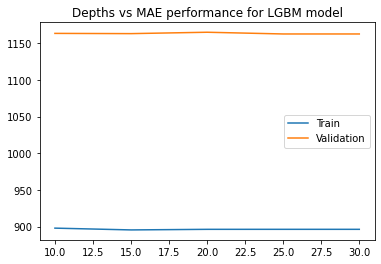

In [452]:
plt.plot(comb,train_mae_result )
plt.plot(comb,test_mae_result)
plt.title("Depths vs MAE performance for LGBM model")
plt.legend(["Train", "Validation"])

In [357]:
best_estimators=1100

In [453]:

best_model_lgbm =lgb.LGBMRegressor(n_jobs=-1,n_estimators=best_estimators,max_depth=12)
best_model_lgbm.fit(X_train_a, y_train_a)
preds=best_model_lgbm.predict(X_validation_a)
best_lgbm_score =xg_eval_mae(preds,y_validation_a)
print("The best validation score of Light gradient boosting is :",best_lgbm_score)

The best validation score of Light gradient boosting is : 1164.3734159839287


# Model-5 ADA Boosting model

In [750]:
from sklearn.ensemble import AdaBoostRegressor

 Because of very high computational time I have used less number of estimators , but in the research I have done in multiple sources , adabosst has been one of the worst performing models despite tuning it .
https://www.kaggle.com/sharmasanthosh/exploratory-study-on-ml-algorithms

In [755]:

n_list = np.array([10,20,30,50,75])


train_mae_result=[]
test_mae_result=[]

comb=[]
for estimators in tqdm(n_list):
    #Set the base model
    model = AdaBoostRegressor(n_estimators=estimators)

    model.fit(X_train_a, y_train_a)
    train_result=xg_eval_mae(y_train_a,(model.predict(X_train_a)))
    train_mae_result.append(train_result)

    val_result = xg_eval_mae(y_validation_a,(model.predict(X_validation_a)))
    test_mae_result.append(val_result)

    comb.append(estimators)

  

    

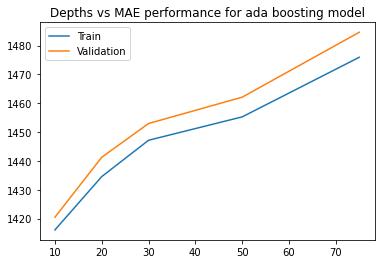

In [756]:
plt.plot(comb,train_mae_result )
plt.plot(comb,test_mae_result)
plt.title("Depths vs MAE performance for ada boosting model")
plt.legend(["Train", "Validation"])

In [757]:
best_estimators=10

In [758]:

best_model_ada =AdaBoostRegressor(n_estimators=estimators)
best_model_ada.fit(X_train_a, y_train_a)
preds=best_model_ada.predict(X_validation_a)
best_ada_score =xg_eval_mae(preds,y_validation_a)
print("The best validation score of ADA boosting is :",best_ada_score)

The best validation score of ADA boosting is : 1492.7508198462388


# Model -5 : XG Boost Model 

In [343]:
d_test = xgb.DMatrix(test_x)

In [96]:

d_train = xgb.DMatrix(X_train_a, label=y_train_a)
d_valid = xgb.DMatrix(X_validation_a, label=y_validation_a)
watchlist = [(d_train, 'train'), (d_valid, 'eval')]

In [360]:
list_depths=np.array([4,12,24,30])

lis_cv_score_train=[]
lis_cv_score_test=[]

for depths in tqdm( list_depths):
    rand_state = 2016

    params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'subsample': 0.7,
        'learning_rate': 0.03,
        'max_depth': depths,
        'min_child_weight': 100,
        'booster': 'gbtree'}

    d_train = xgb.DMatrix(X_train_a, label=y_train_a)
    d_valid = xgb.DMatrix(X_validation_a, label=y_validation_a)
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    steps=1000
    clf = xgb.train(params,
                    d_train,
                    steps,
                    obj=fair_obj,
                    feval=xg_eval_mae)

    scores_train = clf.predict(d_train, ntree_limit=clf.best_ntree_limit)
    cv_score_train = xg_eval_mae((y_train_a), (scores_train))
    lis_cv_score_train.append(cv_score_train)

    print("Train Score of {} at a depth of {}".format(cv_score_train,depths))
    
    scores_test = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
    cv_score_test = xg_eval_mae((y_validation_a), (scores_test))
    lis_cv_score_test.append(cv_score_test)
    
    


Train Score of 1121.5956904742736 at a depth of 4
Train Score of 946.5118408180531 at a depth of 12
Train Score of 777.9259694279586 at a depth of 24
Train Score of 649.864985644112 at a depth of 50



In [361]:
lis_cv_score_train

[1121.5956904742736, 946.5118408180531, 777.9259694279586, 649.864985644112]

In [362]:
lis_cv_score_test

[1158.9885399395844, 1152.0009645742168, 1160.62896325197, 1169.0455683924422]

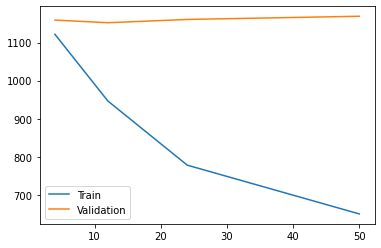

In [363]:

plt.plot(list_depths,lis_cv_score_train)
plt.plot(list_depths,lis_cv_score_test)

plt.legend(["Train", "Validation"])

In [94]:
best_depth=10

In [102]:
params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'subsample': 0.7,
        'learning_rate': 0.03,
        'max_depth':best_depth,
        'min_child_weight': 100,
        'booster': 'gbtree'}

watchlist = [(d_train, 'train'), (d_valid, 'eval')]

steps=1000
best_xgb_model = xgb.train(params,
                d_train,
                steps,
                obj=fair_obj,
                feval=xg_eval_mae)



In [98]:
scores_test = best_xgb_model.predict(d_valid)
best_cv_score_test = mean_absolute_error((y_validation_a), (scores_test))
print("The best validation score of Extreme gradient boosting is :",best_cv_score_test)

The best validation score of Extreme gradient boosting is : 0.37327394652240325


In [100]:
import pickle

In [340]:
dump(best_xgb_model, open('xgb_model.pkl', 'wb'))
modell = load(open('xgb_model.pkl', 'rb'))

In [344]:
modell.predict(d_test)

array([7.458042 , 7.5993834, 9.266754 , ..., 7.8887653, 7.115114 ,
       8.2399845], dtype=float32)

In [101]:
file_name = "xgb_model.pkl"

# save
pickle.dump(best_xgb_model, open(file_name, "wb"))

# Model- 6 CatBoosting for Top features + Autoencoded features

**Why Catboosting ?**

As , here in our data we have huge number of categorical variables , after we find the most important categorical features it would be easier to run the this algorithm as not much of preprocessing would be required in the terms of label encoding or one hot encoding to the data.

Catboosting is relatively new algorithm which has been shown to work very efficiently as some of the best agorithms.It reduces the hassle of peforming extensive hyperparameter tuning also .

In [366]:
# categorical_features_indices = np.where(train_final.dtypes != np.float)[0]

In [463]:
model = CatBoostRegressor(loss_function='MAE',silent=True )
parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 100),
              
             }

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                           cv = 5, n_iter = 20) 
randm.fit(X_train_a, y_train_a)

In [368]:
randm.best_score_

0.5540283011989032

In [369]:
randm.best_params_

{'depth': 6, 'iterations': 64, 'learning_rate': 0.369345687943186}

In [465]:
best_cat_model=CatBoostRegressor(iterations=91, depth=6, learning_rate=0.369345687943186, loss_function='MAE',silent=True)
best_cat_model.fit(X_train_a, y_train_a,eval_set=(X_validation_a, y_validation_a),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [466]:
preds=best_cat_model.predict(X_validation_a)

In [467]:
xg_eval_mae(preds,y_validation_a)

1168.330726398455

# Custom model 

**Data split into 80-20**

In [25]:
X_train_cus, X_validation_cus, y_train_cus, y_validation_cus= train_test_split(train_x,train_y, train_size=0.8, random_state=1234)

In [51]:
def custom_model (X_tr,y_tr,X_val,y_val,test_x,n_estimators):
    print("Starting custom_model ....")
    #Splitting the data into 50-50 D1 and D2
    X_d1, X_d2, y_d1, y_d2= train_test_split(X_tr, y_tr, train_size=0.5, random_state=1234)
    
    
    #Creating Samples out of D1 (X_d1) to create k models to train on
    X_y_d1=X_d1.tolist()
    X_y_d2=X_d2.tolist()
    # grouping the x and y variables together to send it for sampling 
    for i in range (0, len(X_y_d1)):
        X_y_d1[i].append(y_d1.values[i])
        
    k_sampled_data=[]
    print("*"*100)
    print("Creating samples...")
    # creating samples with replacement using random.choice 
    number_of_samples=n_estimators
    for i in tqdm( range (0,number_of_samples)):
        sample_list = random.choices(X_y_d1, k=7532)
        k_sampled_data.append(sample_list)
        
    k_sampled_x=[]
    k_sampled_y=[]
    # splitting the x and y in the sampled data to send it to training the models 
    for sample in k_sampled_data :
        sampled_x=[]
        sampled_y=[]
        for lists in sample:
            sampled_y.append(lists[-1])
            sampled_x.append(lists[:-1])
        k_sampled_x.append(sampled_x)
        k_sampled_y.append(sampled_y)
    print("*"*100)
    print("Creating n_estimators i.e base models...")
    number_of_models=number_of_samples
    models_list=[]
    # Creating a list of 10 models to train 
    for i in range (0,number_of_models):
        model = lgb.LGBMRegressor(n_jobs=-1,n_estimators=1100,max_depth=10)
        models_list.append(model)
        
    print("*"*100)
    print("Training n_estimators i.e base models...")
    predictions_d2=[]
    # Genertaing predictions out of the 10 models with the sampled data 
    for i in tqdm(range(0,len(k_sampled_x))):
        models_list[i].fit(k_sampled_x[i],k_sampled_y[i])
        predictions_d2.append(models_list[i].predict(X_d2))

    data_meta = pd.DataFrame(predictions_d2)
    
    # transpose of dataframe
    data_meta= data_meta.transpose()
    
    print("*"*100)
    print("Training meta model...")
    # Creating the meta model 
    meta_model = lgb.LGBMRegressor(n_jobs=-1,n_estimators=1100,max_depth=10)
    meta_model.fit(data_meta.values,y_d2)

    cus_tr_preds=meta_model.predict(data_meta.values)

    print("The train score of the custom model is :",xg_eval_mae(cus_tr_preds,y_d2))
    score_cus_model_tr=xg_eval_mae(cus_tr_preds,y_d2)
    
    #Checking the meta model's performance on the rest of the 20% data 
    predictions_valid=[]
    # Genertaing predictions out of the 10 models with the sampled data 
    for i in tqdm(range(0,len(models_list))):
        predictions_valid.append(models_list[i].predict(X_val))

    data_meta_valid = pd.DataFrame(predictions_valid)    
    data_meta_valid= data_meta_valid.transpose()
    # print(" dataframe is-\n", )
    # data_meta   

    # testing the meta model 

    cus_val_preds=meta_model.predict(data_meta_valid.values)

    print("The validation score of the custom model is :",xg_eval_mae(cus_val_preds,y_validation_cus))
    score_cus_model_val=xg_eval_mae(cus_val_preds,y_val)
    
    
    predictions_tr=[]
    predictions_va=[]
    predictions_te=[]
    # Generating predictions out of the 10 models with the sampled data 
    for i in tqdm(range(0,len(models_list))):
        predictions_tr.append(models_list[i].predict(X_train_a))
        predictions_va.append(models_list[i].predict(X_validation_a))
        predictions_te.append(models_list[i].predict(test_x))


    data_meta_tr = pd.DataFrame(predictions_tr)    
    data_meta_tr= data_meta_tr.transpose()

    data_meta_va = pd.DataFrame(predictions_va)    
    data_meta_va= data_meta_va.transpose()    

    data_meta_te = pd.DataFrame(predictions_te)    
    data_meta_te= data_meta_te.transpose()
    # print(" dataframe is-\n", )
    # data_meta   

    # testing the meta model 
    print("*"*100)
    print("Generating predictions .....")
    predictions_cus_tr=meta_model.predict(data_meta_tr.values)
    predictions_cus_va=meta_model.predict(data_meta_va.values)
    predictions_cus_te=meta_model.predict(data_meta_te.values)

    # print("The score of the custom model is :",xg_eval_mae(cus_val_preds,y_validation_cus))
    # predictions_cus_va=xg_eval_mae(cus_val_preds,y_validation_cus)
    print("*"*100)
    print("Computations done")
    return predictions_cus_tr , predictions_cus_va ,predictions_cus_te
    
    

In [55]:
predictions_cus_tr , predictions_cus_va ,predictions_cus_te=custom_model(X_train_cus,y_train_cus,X_validation_cus,
                                                                         y_validation_cus,test_x,100)

Starting custom_model ....
****************************************************************************************************
Creating samples...



****************************************************************************************************
Creating n_estimators i.e base models...
****************************************************************************************************
Training n_estimators i.e base models...



****************************************************************************************************
Training meta model...
The train score of the custom model is : 774.9390478749389



The validation score of the custom model is : 1194.3416245505612



****************************************************************************************************
Generating predictions .....
****************************************************************************************************
Computations done


In [35]:
import random

In [56]:
score_cus_model_tr=774.9390478749389
score_cus_model_val=1194.3416245505612

# Stacking all the model's outputs

**Linear model predictions**

In [373]:
predictions_lr_tr=linear_model.predict(X_train_a)
predictions_lr_va=linear_model.predict(X_validation_a)


In [374]:
score_lr_model_tr=xg_eval_mae(predictions_lr_tr,y_train_a)
score_lr_model_val=xg_eval_mae(predictions_lr_va,y_validation_a)

In [378]:
predictions_lr_te=linear_model.predict(test_final)

**Ridge model Predictions**

In [379]:
predictions_rid_tr=ridge_model.predict(X_train_a)
predictions_rid_va=ridge_model.predict(X_validation_a)



In [380]:
score_rid_model_tr=xg_eval_mae(predictions_rid_tr,y_train_a)
score_rid_model_val=xg_eval_mae(predictions_rid_va,y_validation_a)

In [381]:
predictions_rid_te=ridge_model.predict(test_x)

**Random forest predictions**

In [382]:
predictions_rf_tr=best_model_rf.predict(X_train_a)
predictions_rf_va=best_model_rf.predict(X_validation_a)

In [383]:
score_rf_model_tr=xg_eval_mae(predictions_rf_tr,y_train_a)
score_rf_model_val=xg_eval_mae(predictions_rf_va,y_validation_a)

In [384]:
predictions_rf_te=best_model_rf.predict(test_x)

**Light gradient boosting predictions**

In [385]:
predictions_lgbm_tr=best_model_lgbm.predict(X_train_a)
predictions_lgbm_va=best_model_lgbm.predict(X_validation_a)

In [386]:
score_lgbm_model_tr=xg_eval_mae(predictions_lgbm_tr,y_train_a)
score_lgbm_model_val=xg_eval_mae(predictions_lgbm_va,y_validation_a)

In [387]:
predictions_lgbm_te=best_model_lgbm.predict(test_x)

**Xgboost predictions**

In [388]:
predictions_xgb_tr=best_xgb_model.predict(d_train, ntree_limit=clf.best_ntree_limit)
predictions_xgb_va=best_xgb_model.predict(d_valid, ntree_limit=clf.best_ntree_limit)

In [389]:
score_xgb_model_tr=xg_eval_mae(predictions_xgb_tr,y_train_a)
score_xgb_model_val=xg_eval_mae(predictions_xgb_va,y_validation_a)

In [390]:
predictions_xgb_te=best_xgb_model.predict(d_test, ntree_limit=clf.best_ntree_limit)

**Cat boosting predictions**

In [391]:
predictions_cat_tr=best_cat_model.predict(X_train_a)
predictions_cat_va=best_cat_model.predict(X_validation_a)

In [392]:
score_cat_model_tr=xg_eval_mae(predictions_cat_tr,y_train_a)
score_cat_model_val=xg_eval_mae(predictions_cat_va,y_validation_a)

In [393]:
predictions_cat_te=best_cat_model.predict(test_x)

**ADA Boosting predictions**

In [760]:
predictions_ada_tr=best_model_ada.predict(X_train_a)
predictions_ada_va=best_model_ada.predict(X_validation_a)

In [761]:
score_ada_model_tr=xg_eval_mae(predictions_ada_tr,y_train_a)
score_ada_model_val=xg_eval_mae(predictions_ada_va,y_validation_a)

In [762]:
predictions_ada_te=best_model_ada.predict(test_x)

**Custom model predictions**

In [ ]:
predictions_cus_tr,predictions_cus_va

In [649]:
predictions_cus_te

array([7.43070237, 7.62634364, 9.00322783, ..., 7.80228735, 7.07588133,
       8.21483078])

# Processing data for stack model

In [763]:
train_predictions = {'linear_model': predictions_lr_tr, 
                     'ridge_model': predictions_rid_tr, 
                     'Random_forest_model': predictions_rf_tr,
                     'LGB_model':predictions_lgbm_tr,
                     'XGB_model':predictions_xgb_tr,
                     'CATB_model':predictions_cat_tr,
                     'Custom_model':predictions_cus_tr,
                     'ADA boost model':predictions_ada_tr,
                     'loss':y_train_a
                    }
train_stack_data=df = pd.DataFrame(train_predictions)

In [766]:
valid_predictions = {'linear_model': predictions_lr_va, 
                     'ridge_model': predictions_rid_va, 
                     'Random_forest_model': predictions_rf_va,
                     'LGB_model':predictions_lgbm_va,
                     'XGB_model':predictions_xgb_va,
                     'CATB_model':predictions_cat_va,
                     'Custom_model':predictions_cus_va,
                     'ADA boost model':predictions_ada_va,
                     'loss':y_validation_a
                    }

valid_stack_data=df = pd.DataFrame(valid_predictions)

In [767]:
test_predictions = {'linear_model': predictions_lr_te, 
                     'ridge_model': predictions_rid_te, 
                     'Random_forest_model': predictions_rf_te,
                     'LGB_model':predictions_lgbm_te,
                     'XGB_model':predictions_xgb_te,
                     'CATB_model':predictions_cat_te,
                     'Custom_model':predictions_cus_te,
                    'ADA boost model':predictions_ada_te
                     
                    }

test_stack_data=df = pd.DataFrame(test_predictions)

In [768]:
total_data_stack=train_stack_data.append(valid_stack_data)

In [769]:
total_data_stack.to_csv('total_data_stack.csv', index=False)

In [770]:
test_stack_data.to_csv('test_stack_data.csv', index=False)

In [771]:
total_data_stack

,linear_model,ridge_model,Random_forest_model,LGB_model,XGB_model,CATB_model,Custom_model,ADA boost model,loss
60203,8.216901,8.191256,8.473664,8.456917,8.527285,8.389185,8.562708,7.855208,8.605616
149561,7.635088,7.634567,7.604635,7.673231,7.608187,7.667861,7.459461,7.543962,7.688070
148203,7.726191,7.729416,7.554507,7.717031,7.719320,7.702456,7.611661,7.652509,7.403713
110220,7.251479,7.244436,7.268473,6.931572,6.963175,6.862273,7.052833,7.431768,7.447256
88655,7.313561,7.313356,6.745816,7.091314,7.045321,7.094250,7.008234,7.511629,6.527592
...,...,...,...,...,...,...,...,...,...
2005,7.959243,7.966692,7.685393,7.902273,8.167639,8.051675,8.048504,7.691234,8.482030
61904,7.701121,7.712480,7.744481,7.676100,7.639033,7.626861,7.419859,7.561648,7.335269
42243,8.591953,8.561455,8.550178,8.521813,8.771398,8.945244,8.393508,7.991030,8.220244
178649,8.075890,8.075667,7.759576,7.992255,8.007330,8.058330,8.000234,7.923151,7.649145


In [707]:
y=total_data_stack['loss'].values
X=total_data_stack.drop(['loss'],axis=1).values


In [708]:
X_train_stack, X_test_stack, y_train_stack, y_test_stack= train_test_split(X, y, test_size=0.33, random_state=1)


# Stacking all the models with neural net

In [709]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU


In [710]:
def nn_model():
    model = Sequential()
    model.add(Dense(256, input_dim = X_train_stack.shape[1],bias_initializer  = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.6))
    model.add(Dense(128, bias_initializer = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.8))
    model.add(Dense(1, bias_initializer = 'he_normal'))
    model.compile(loss = 'mae', optimizer = 'adam')
    return(model)

In [711]:
model = nn_model()

In [712]:
history = model.fit(X_train_stack,y_train_stack, epochs=50, batch_size=16, verbose=2,
                    validation_data=(X_test_stack,y_test_stack))

Epoch 1/50
7886/7886 - 7s - loss: 1.1611 - val_loss: 0.3881
Epoch 2/50
7886/7886 - 7s - loss: 0.6418 - val_loss: 0.3044
Epoch 3/50
7886/7886 - 7s - loss: 0.4049 - val_loss: 0.2406
Epoch 4/50
7886/7886 - 7s - loss: 0.3322 - val_loss: 0.2503
Epoch 5/50
7886/7886 - 7s - loss: 0.3093 - val_loss: 0.2317
Epoch 6/50
7886/7886 - 7s - loss: 0.2978 - val_loss: 0.2184
Epoch 7/50
7886/7886 - 7s - loss: 0.2945 - val_loss: 0.2174
Epoch 8/50
7886/7886 - 7s - loss: 0.2892 - val_loss: 0.2001
Epoch 9/50
7886/7886 - 7s - loss: 0.2846 - val_loss: 0.1961
Epoch 10/50
7886/7886 - 7s - loss: 0.2820 - val_loss: 0.2012
Epoch 11/50
7886/7886 - 7s - loss: 0.2813 - val_loss: 0.1991
Epoch 12/50
7886/7886 - 7s - loss: 0.2789 - val_loss: 0.2140
Epoch 13/50
7886/7886 - 7s - loss: 0.2765 - val_loss: 0.1999
Epoch 14/50
7886/7886 - 7s - loss: 0.2777 - val_loss: 0.2010
Epoch 15/50
7886/7886 - 7s - loss: 0.2746 - val_loss: 0.2422
Epoch 16/50
7886/7886 - 7s - loss: 0.2740 - val_loss: 0.2042
Epoch 17/50
7886/7886 - 7s - loss

In [713]:
predictions_final_tr=model.predict(X_train_stack)
predictions_final_va=model.predict(X_test_stack)

In [714]:
score_final_model_tr=xg_eval_mae(predictions_final_tr,y_train_stack)
score_final_model_val=xg_eval_mae(predictions_final_va,y_test_stack)

# Total conculsions of all the models 

In [772]:
from prettytable import PrettyTable
x = PrettyTable(["Model", "Train_score", "Validation_score"])

x.add_row(["LINEAR",score_lr_model_tr,score_lr_model_val])
x.add_row(["RIDGE",score_rid_model_tr,score_rid_model_val])
x.add_row(["RANDOM FOREST",score_rf_model_tr,score_rf_model_val])
x.add_row(["LGB",score_lgbm_model_tr,score_lgbm_model_val])
x.add_row(["XB BOOST", score_xgb_model_tr,score_xgb_model_val])
x.add_row(["ADA Boost model",score_ada_model_tr,score_ada_model_val])
x.add_row(["CAT BOOST",score_cat_model_tr,score_cat_model_val])
x.add_row(["Custom model",score_cus_model_tr,score_cus_model_val])
x.add_row(["STACKED NN",score_final_model_tr,score_final_model_val])
print(x)

+-----------------+--------------------+--------------------+
|      Model      |    Train_score     |  Validation_score  |
+-----------------+--------------------+--------------------+
|      LINEAR     | 1275.3688932831012 | 1287.5050116516882 |
|      RIDGE      | 1277.523390573013  | 1288.9717906134154 |
|  RANDOM FOREST  | 493.2452988542854  | 1221.6866477937106 |
|       LGB       | 1123.8511865527732 | 1164.500744817816  |
|     XB BOOST    | 987.3777002483365  | 1151.2101706696205 |
| ADA Boost model | 1482.281041332547  | 1492.7508198462388 |
|    CAT BOOST    | 1105.8949960900638 | 1171.5396738889472 |
|   Custom model  | 959.5276922643731  | 1210.5860455660536 |
|    STACKED NN   | 618.3449150546226  | 622.2173759931214  |
+-----------------+--------------------+--------------------+


# Predictions on test data 

In [729]:
pred_l=np.exp(model.predict(test_stack_data))-shift

test_pred_list= list(itertools.chain(*pred_l.tolist()))


In [730]:
ids=test_data['id']
submission = pd.DataFrame()
submission['loss'] = test_pred_list
submission['id'] = ids
submission.to_csv('stacked_nn_model.csv', index=False)

In [732]:
list_model_st=['lr','rid','rf','lgbm','ada','xgb','cat','cus']

In [736]:
list_test_preds=[predictions_lr_te,predictions_rid_te,predictions_rf_te,
                 predictions_lgbm_te,predictions_ada_te,predictions_xgb_te,predictions_cat_te,
                predictions_cus_te]

In [747]:
# for i in range (0, len(list_test_preds)):
#     for j in range (0, len(list_test_preds)):
#         score=xg_eval_mae(list_test_preds[i],list_test_preds[j])
#         print("MAE between {} and {} is {}".format(list_model_st[i],list_model_st[j],score))
#     print("*"*100)
    

In [742]:
for i in range(0,len(list_test_preds)):
    ids=test_data['id']
    submission = pd.DataFrame()
    preds=np.exp(list_test_preds[i])-shift
    preds=preds.tolist()
    submission['loss'] = preds
    submission['id'] = ids
    submission.to_csv('{}_model.csv'.format(list_model_st[i]), index=False)

In [ ]:
predictions_cus_te

In [57]:
ids=test_data['id']
submission = pd.DataFrame()
preds=np.exp(predictions_cus_te)-shift
preds=preds.tolist()
submission['loss'] = preds
submission['id'] = ids
submission.to_csv('Custom_model3.csv', index=False)

# Kaggle submission scores

The right score is public score and left is private score .

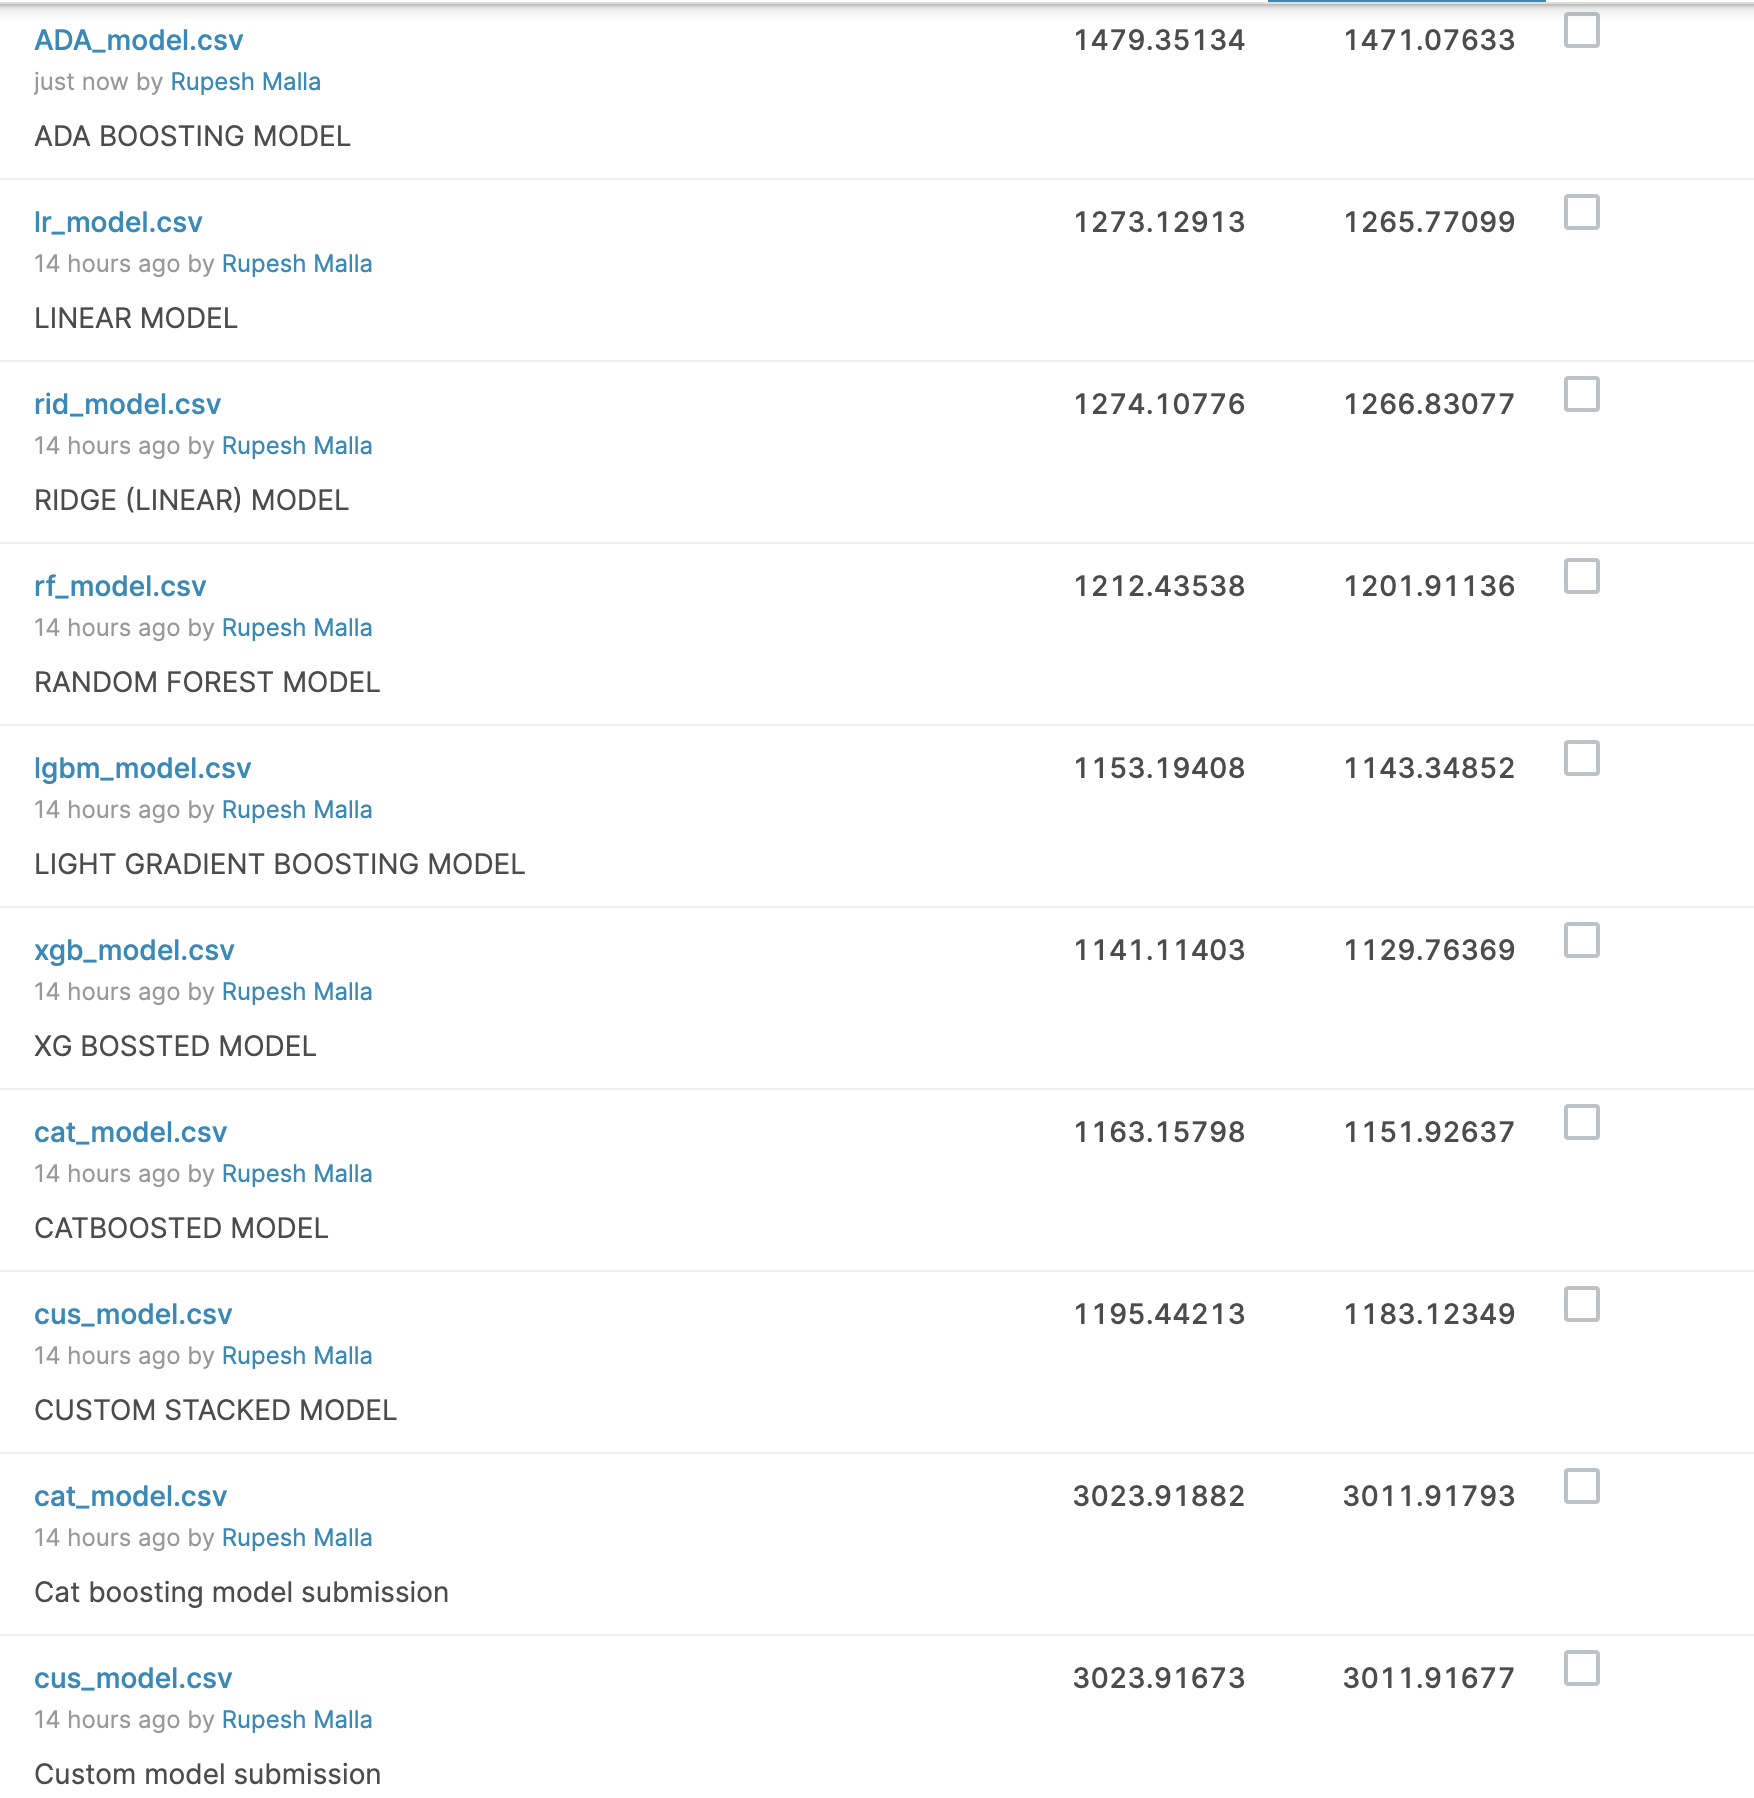

In [59]:
from IPython.display import Image
Image(filename='/Users/rupesh/Desktop/Screenshot 2021-05-06 at 11.27.54 AM.png')

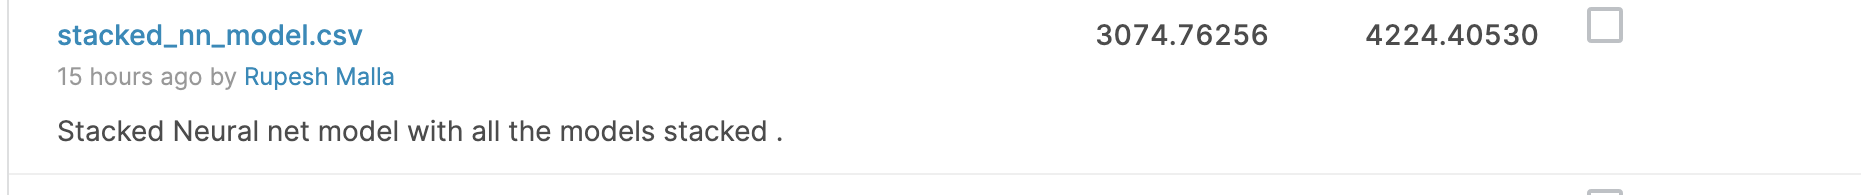

In [776]:
# src2='Screenshot 2021-05-06 at 11.28.19 AM'
Image(filename='/Users/rupesh/Desktop/Screenshot 2021-05-06 at 11.36.01 AM.png')

**RESULTS OF CUSTOM MODELS WITH DIFFERENT NUMBER OF BASE MODELS**

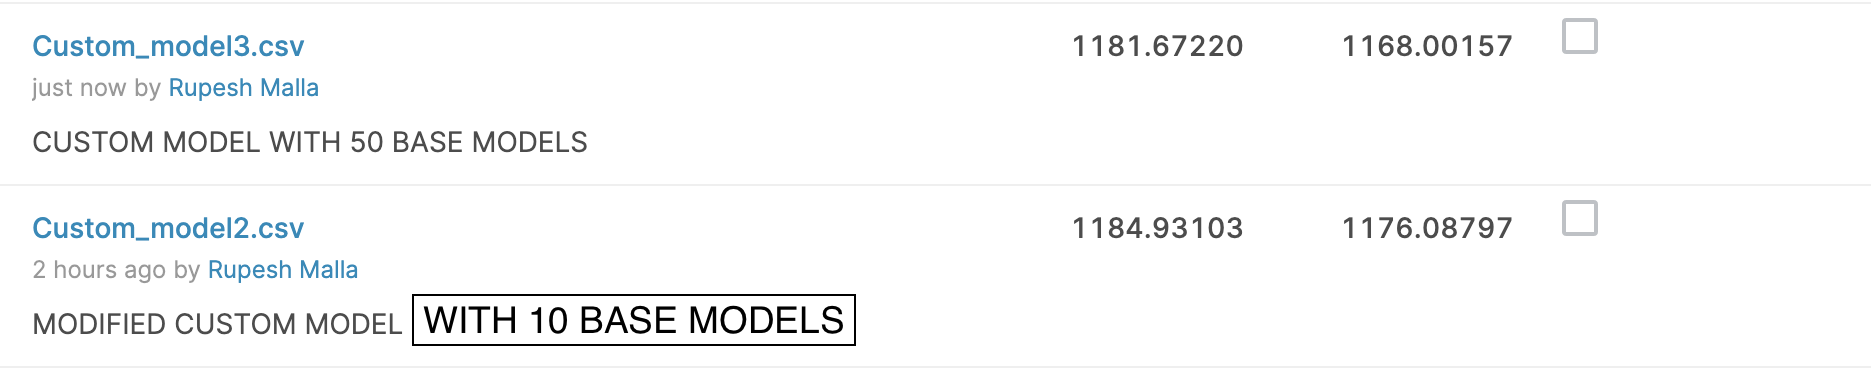

In [60]:
Image(filename='/Users/rupesh/Desktop/Screenshot 2021-05-07 at 7.56.19 PM.png')